In [1]:
# pip install pyemu  # pestpp_tester.yml  # from a01_model_setup import generate_1d_model  # w_a02_od_flow_template

In [2]:
import time ; 
start_time = time.time()
import os, sys ; import numpy as np ; import pandas as pd ; import configparser ; import pyemu
import matplotlib.pyplot as plt     ; import inspect      ; import shutil       ; import flopy
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\02_PEST_pp\01_one_dim_flow


In [3]:
vs_code_dir = r"E:\15_REPOS\00_BETAMI\02_PEST_pp\01_one_dim_flow"
config      = configparser.ConfigParser()
config.read (r"E:\15_REPOS\00_BETAMI\02_PEST_pp\01_one_dim_flow\data")

[]

In [4]:
template_ws = os.path.join(".","w_a02_od_flow_template") # od_flow os one dim flow model
if not(os.path.isdir(template_ws)):
    os.mkdir(template_ws)
else:
    shutil.rmtree(template_ws)
print(os.path.abspath(template_ws))

E:\15_REPOS\00_BETAMI\02_PEST_pp\01_one_dim_flow\w_a02_od_flow_template


FloPy is using the following executable to run the model: ..\..\..\bin\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: flow_1d.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/02/15 14:54:00

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/02/15 14:54:00
 Elapsed run time:  0.016 Seconds

  Normal termination of simulation


[NbConvertApp] Converting notebook a01_model_setup.ipynb to script
[NbConvertApp] Writing 2834 bytes to a01_model_setup.py


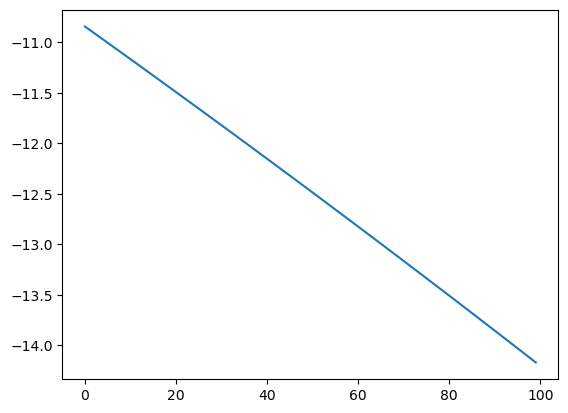

In [5]:
from a01_model_setup import generate_1d_model
generate_1d_model() 

In [6]:
shutil.copytree('w_a01_model_dataset', os.path.join(template_ws, 'w_a01_model_dataset'))
shutil.rmtree('w_a01_model_dataset')

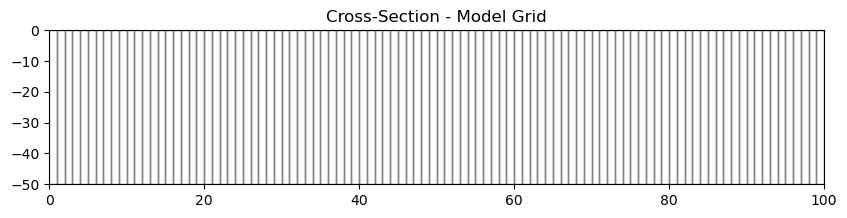

In [7]:
fnam  = os.path.join(template_ws, r'w_a01_model_dataset\flow_1d.nam')
mf    = flopy.modflow.Modflow.load(os.path.basename(fnam), model_ws= os.path.dirname(fnam))
fig   = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(1, 1, 1)       ; xsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
linecollection = xsect.plot_grid()  ; t = ax.set_title('Cross-Section - Model Grid')

In [ ]:
np.random.seed(42)
corr_scale = 50
nx, ny = mf.nrow, mf.ncol # of cells
N = 50 # number of realizations
m = 5 # number of measurements
refence_realization = 4
delc = mf.dis.delc.array
delr = mf.dis.delr.array

# pyemu allow us to define the spatial structure of grid. This object (sr) will be used later.
sr = pyemu.helpers.SpatialReference(delr=delr, delc=delc )

## 2b) Our model has two input files: index.dat and inputx.csv. The index.csv contains the indeces of measurement locations.
#   and inputx.dat has all interpolated values. I like to setup model so that I have only one input file and one output file. 
#   A python script will be used to read and process the input file and apply it to MODFLOW files. In a similair way, modflow output files
#   will be read by the script and merged in one file.

# here we generate a template input file. The input file has the log10 conductivity
inputx = np.zeros_like(delr)
inputx = inputx[np.newaxis, :]
np.savetxt(os.path.join(template_ws, 'inputx.dat'), inputx)

# another input file that will not contain parameters, but just indexces of head measurments.
df_index = pd.DataFrame()
yi = np.linspace(2,ny-2,m) # measurement index
df_index['idx'] = yi
df_index.to_csv(os.path.join(template_ws, 'index.csv'))

In [ ]:
script ="""
import os, sys
import numpy as np
import pandas as pd
import flopy
def forward_model():
    # try to delete output file
    try:
        os.remove("heads_out.csv")
    except:
        pass
    # index
    indx = pd.read_csv('index.csv')['idx'].values.astype(int)   
    
    # read input file    
    x = np.loadtxt('inputx.dat')
    x = np.power(10.0, x)
    mf = flopy.modflow.Modflow.load(r'flow_1d.nam', model_ws = 'w_a01_model_dataset' )
    
    hk = mf.upw.hk.array.copy()
    hk = x[np.newaxis, np.newaxis, :]
    mf.upw.hk = hk
    mf.upw.write_file()

    basefolder = os.getcwd()
    os.chdir("w_a01_model_dataset")
    os.system("mfnwt.exe flow_1d.nam")
    os.chdir(basefolder)

    hds = flopy.utils.HeadFile(os.path.join('w_a01_model_dataset', 'flow_1d.hds'))
    wl = hds.get_data(totim=1.0)
    wl = wl.squeeze()
    # model maping   
    y =wl[indx]
    
    # write model output
    out = pd.DataFrame()
    out['y'] = y
    out.to_csv('heads_out.csv', index_label = 'id')
    
if __name__ == "__main__":
    forward_model()

"""
with open(os.path.join(template_ws, r"forward_model.py"), 'w') as fidw:
    fidw.write(script)

In [ ]:
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

# PstFrom to setup the problem.

In [ ]:
# Generate a pf object
new_d =  os.path.join(".", "new_"+os.path.basename(template_ws))
pf = pyemu.utils.PstFrom(original_d=template_ws, new_d=new_d,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False,start_datetime="1-1-2018", multi_threads = False)

In [ ]:
# add input file that contains parameters
par_fn = 'inputx.dat'
par_name_base = 'kx'
pargp = 'KH'

v = pyemu.utils.geostats.ExpVario(a=corr_scale,contribution=1.0)
grid_gs = pyemu.utils.geostats.GeoStruct(variograms=v,nugget=0.0)

pf.add_parameters(filenames=par_fn, par_type="grid",
                  par_name_base=par_name_base, pargp=pargp,
                  upper_bound=5., lower_bound=-5, ult_ubound=3.0, ult_lbound=-3,
                  geostruct=grid_gs, transform='none', par_style='direct')

In [ ]:
output_file = r'heads_out.csv'
df_out = pd.read_csv(os.path.join(new_d, output_file), index_col=0)
ins_file =output_file + ".ins"
obs_prefix = 'h' ## Note: using capital letter will cause issues
obsgp = 'heads'
hds_df = pf.add_observations(output_file,insfile=ins_file,index_cols="id",
                    use_cols=list(df_out.columns),prefix=obs_prefix, obsgp = obsgp, ofile_sep = ",")


In [ ]:
pf.mod_sys_cmds.append(cmd)
pst = pf.build_pst(version=2)

pe = pf.draw(num_reals=N, sigma_range= 10, use_specsim=True)
pe.to_csv(os.path.join(new_d, 'HKensemble.csv'))
## Select one realization to represent the unknown truth (the actual reference field). From this truth realization choose observations.
x_true = pe._df.iloc[refence_realization].values

In [ ]:
plt.figure()
plt.plot(pe._df.T.values)
plt.show()

ens =  pe._df.values.T
y_ref = ens[:, refence_realization]
y_index = df_index['idx'].astype(int).values # measurement index

print(y_ref[y_index])
print(y_index)

plt.figure()
plt.plot(ens, color = [0.7,0.7,0.7], zorder=1)
plt.plot(ens[:,refence_realization])
plt.scatter(y_index, y_ref[y_index], color = 'r', zorder = 2)
plt.show()

In [ ]:
# this a synthatic problem, so we need observations. The observation is generated from the reference realization
inputx = y_ref + np.zeros_like(delr)
inputx = inputx[np.newaxis, :]
np.savetxt(os.path.join(template_ws, 'inputx.dat'), inputx)

In [ ]:
# run the model using the synthatic realization
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

In [ ]:
# read output
df_obs = pd.read_csv(os.path.join(template_ws,'heads_out.csv'))
df_obs

In [ ]:
## use observation from the refernce
pst.observation_data['obsval'] = df_obs['y'].values
pst.observation_data['weight'] = 1000 # this is 1/std
pst.observation_data['cycle'] = 0 # ensemble smoother
#pst.observation_data['state_par_link']

pst.parameter_data['cycle'] = 0
pst.parameter_data['parchglim'] = 'relative'
pst.model_input_data['cycle'] = 0
pst.model_output_data['cycle'] = 0

pst.svd_data.eigthresh =  1e-5
pst.pestpp_options['da_add_base']= False
pst.pestpp_options['da_parameter_ensemble']= 'HKensemble.csv'
#pst.pestpp_options['DA_SUBSET_SIZE'] = 50
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['ies_init_lam'] = [1]
pst.pestpp_options['ies_lambda_mults'] = 1
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 1

In [ ]:
pst.model_command[0] = pst.model_command[0].replace('python', sys.executable)
pst.write(os.path.abspath(pf.pst.filename), version=2)

## Important check locations of ins and templpe

In [ ]:
shutil.copy2(os.path.join(vs_code_dir,"exe","windows","x64","Debug","pestpp-da.exe"),os.path.join(new_d,"pestpp-da.exe"))

In [ ]:
import subprocess
base_folder = os.getcwd()
os.chdir(new_d)
argv = ["pestpp-da.exe", os.path.basename(pf.pst.filename)]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)

In [ ]:
posterior_par = pd.read_csv(os.path.join(new_d, template_ws+".global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')


In [ ]:
## Try more iterations for 

In [ ]:
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['DA_SUBSET_SIZE'] = 10
pst.pestpp_options['ies_init_lam'] = [10]
pst.pestpp_options['ies_lambda_mults'] = [0.1, 1, 10]
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 5 # number of iterations
pst.write(os.path.abspath(pf.pst.filename), version=2)

In [ ]:
import subprocess
base_folder = os.getcwd()
os.chdir(new_d)
argv = ["pestpp-da.exe", os.path.basename(pf.pst.filename)]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)

In [ ]:
posterior_par = pd.read_csv(os.path.join(new_d, template_ws+".global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')

In [ ]:
sys.path.append(r"..")
import rec_util 
import rec_util
ws = r"D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow\new_w_a02_od_flow_template"
fname = r"w_a02_od_flow_template.rec"

fname = os.path.join(ws, fname)
rec = rec_util.RecFile(fname= os.path.join(new_d, template_ws+".rec"))

